In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax.numpy as jnp
import jax
from functools import partial, wraps
from scipy.special import erf, erfc
import scipy

In [2]:
import lib

In [3]:
class Neuron10_2_Y(lib.Neuron10_2):
    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        updated_w = w[updated_idx] + jnp.heaviside(self.kappa-updated_overlap, 0.).reshape((-1, 1))*(x[updated_idx]*(self.kappa-updated_overlap).reshape((-1, 1)) - self.beta*w[updated_idx])/self.ns # dim = (ndR, ns)
        latent_var = updated_idx
        return w.at[updated_idx].set(updated_w), latent_var
    
class Neuron11_2_Y(lib.Neuron11_2):
    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        updated_w = w[updated_idx] + jnp.heaviside(self.kappa+self.b-updated_overlap, 0.).reshape((-1, 1))*(x[updated_idx]*(self.kappa+self.b-(1-self.beta/self.ns)*updated_overlap).reshape((-1, 1)) - self.beta*w[updated_idx])/self.ns # dim = (ndR, ns)
        latent_var = updated_idx
        return w.at[updated_idx].set(updated_w), latent_var
    
class Neuron11_2_2_Y(lib.Neuron11_2):
    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) # dim = (nd, )
        x_parallel = overlaps / jnp.linalg.norm(w, axis=-1)
        _, updated_idx = jax.lax.top_k(x_parallel, self.ndR)
        updated_overlap = overlaps[updated_idx]
        updated_w = w[updated_idx] + jnp.heaviside(self.kappa+self.b-updated_overlap, 0.).reshape((-1, 1))*(x[updated_idx]*(self.kappa+self.b-(1-self.beta/self.ns)*updated_overlap).reshape((-1, 1)) - self.beta*w[updated_idx])/self.ns # dim = (ndR, ns)
        latent_var = updated_idx
        return w.at[updated_idx].set(updated_w), latent_var

class Neuron3_2_Y(lib.Neuron3_2):
    @wraps(partial(jax.jit, static_argnums=(0, )))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        updated_w = w[updated_idx] + jax.nn.relu(self.kappa - updated_overlap).reshape((-1, 1))*x[updated_idx]/self.ns # dim = (ndR, ns)
        updated_w = updated_w/jnp.linalg.norm(updated_w, ord=2, axis=-1, keepdims=True)
        latent_var = updated_idx
        return w.at[updated_idx].set(updated_w), latent_var

class Simulation_Run_Y_distribution():
    def __init__(self, neuron: Neuron11_2_Y, xs_gen: lib.Xs_Generator, decay_steps=500, initial_steps=500, n_tested_patterns=100, refresh_every=1000, seed=42) -> None:
        self.key = jax.random.PRNGKey(seed)
        self.key, subkey1, subkey2 = jax.random.split(self.key, 3)
        self.neuron = neuron
        self.decay_steps = decay_steps
        self.initial_steps = initial_steps
        self.n_test_patterns = n_tested_patterns
        self.refresh_every = max(refresh_every, n_tested_patterns)
        self.xs_gen = xs_gen
        self.xs = self.xs_gen.gen(subkey1, self.refresh_every)
        self.init_w(subkey2)

        self.overlaps_record = np.zeros((n_tested_patterns, self.neuron.nd))
        self.updated_idx_record = np.zeros((n_tested_patterns, self.neuron.ndR))

    @partial(jax.jit, static_argnums=(0, ))
    def neuron_update_fun(self, w, x, latent_var):
        return self.neuron.update_fun(w, x, latent_var)

    def init_w(self, key):
        for i  in range(self.initial_steps):
            if i%self.refresh_every == 0:
                subkey, key = jax.random.split(key)
                xs0 = self.xs_gen.gen(subkey, self.refresh_every)
            self.neuron.w, self.neuron.latent_var = self.neuron_update_fun(self.neuron.w, xs0[i%self.refresh_every], self.neuron.latent_var)

    @partial(jax.jit, static_argnums=(0, ))
    def _update(self, w, latent_var, x):
        w, latent_var = self.neuron_update_fun(w, x, latent_var)
        # votes = jax.vmap(self.neuron.get_votes, in_axes=(None, 0))(w, x0s) # dim=(n_tested_patterns, )
        return w, latent_var

    def run(self, t, progress_bar=True):
        self.key, subkey = jax.random.split(self.key)
        self.xs = self.xs_gen.gen(subkey, self.refresh_every)        
        x0s = self.xs[:self.n_test_patterns] # in jax numpy, a copy is created for x0s
        if progress_bar is True: 
            pb = tqdm(range(t+self.n_test_patterns))
        else:
            pb = range(t+self.n_test_patterns)
        for i in pb:
            if i%self.refresh_every == 0 and i>=self.refresh_every:
                self.key, subkey = jax.random.split(self.key)
                self.xs = self.xs_gen.gen(subkey, self.refresh_every)
            self.neuron.w, self.neuron.latent_var = self._update(self.neuron.w, self.neuron.latent_var, self.xs[i%self.refresh_every])
            if i >= t:
                idx_tmp = i-t
                overlaps = np.sum(self.neuron.w*x0s[idx_tmp], axis=-1) # dim = (nd, )
                self.overlaps_record[idx_tmp] = overlaps
            if i < self.n_test_patterns:
                self.updated_idx_record[i] = self.neuron.latent_var

In [4]:
n_iterations = 30
t=2500

ns=300
nd=200
rho = 1
bias = 2.75
ndR = 4
kappa = 2.25
n_votes = nd
vote_th = bias
# la = 0.445556
beta = 10.0242

decay_steps = 2000
n_tested_patterns = 4000
initial_steps = 5000

uII_records = np.zeros((n_iterations, n_tested_patterns, ndR))

seed = 1029
rng = np.random.default_rng(seed)

neuron2 = Neuron11_2_Y(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, beta=beta, vote_th=vote_th, seed=rng.integers(100000))
xs_gen = lib.Xs_Generator3_2(nd, ns, rho, normalized_len=np.sqrt(ns), seed=rng.integers(100000))
simulation_run2 = Simulation_Run_Y_distribution(neuron2, xs_gen, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, refresh_every=500, seed=rng.integers(100000))


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
for i in range(n_iterations):
    simulation_run2.run(t=t)
    
    tmp = np.ones((n_tested_patterns, 1), dtype=int)*np.arange(nd, dtype=int)
    tmpII = simulation_run2.updated_idx_record.astype(int)
    uII_record = simulation_run2.overlaps_record[np.arange(n_tested_patterns, dtype=int).reshape((-1, 1))*np.ones(ndR, dtype=int), tmpII]
    uII_records[i] = uII_record
    
    

100%|██████████| 6500/6500 [00:11<00:00, 585.11it/s] 


In [13]:
uII_records = uII_records.reshape((-1, ))

In [14]:
theory_u = np.genfromtxt("tmp_data/tmpListuII.csv", delimiter=',')

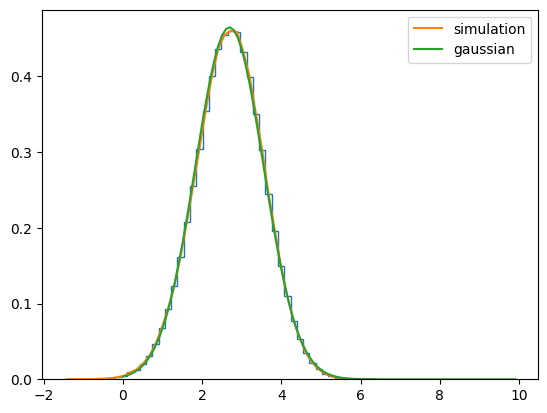

In [15]:
ys, xs, _ = plt.hist(uII_records, bins=50, density=True, histtype="step", cumulative=False)
xs = (xs[:-1]+xs[1:])/2
plt.plot(xs, ys, label="simulation")
def tmpfun(y, a, mu, sigma):
    return (1-a)*np.exp(-(y-mu)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2)/0.5/(1+erf(mu/sigma/np.sqrt(2.)))
def tmpfunCum(y, a, mu, sigma):
    return a + (1-a)*(erf((y-mu)/sigma/np.sqrt(2))+erf(mu/sigma/np.sqrt(2.)))/(1+erf(mu/sigma/np.sqrt(2.)))
# plt.plot(np.arange(0, 10, 0.1), tmpfun(np.arange(0, 10, 0.1), 0.000025, 4.19078, 1.26685))
plt.plot(np.arange(0, 10, 0.1), tmpfun(np.arange(0, 10, 0.1), 0.0000, np.mean(uII_records), np.std(uII_records)), label="gaussian")
# plt.plot(theory_u[:, 0], theory_u[:, 1], label="skew gaussian")
# plt.xlim(0, 8)
# plt.xlim(1, 3)
# plt.ylim(0, 0.1)
plt.legend()

In [9]:
theory_YII = np.genfromtxt("tmp_data/tmpListYII.csv", delimiter=',')

In [16]:
uII_records = uII_records.reshape((n_iterations, n_tested_patterns, ndR))
zII_records = (uII_records-bias)*(uII_records-bias>0)
# zII_records = (uII_records-bias)
YII_records = np.sum(zII_records, axis=-1)

In [34]:
YII_records = YII_records.reshape((-1, ))
zII_records = zII_records.reshape((-1, ))

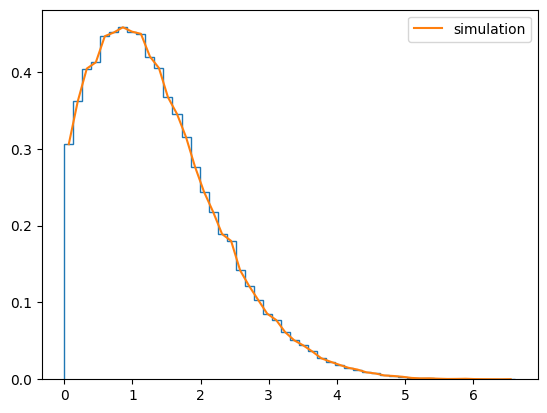

In [38]:
ys, xs, _ = plt.hist(YII_records, bins=50, density=True, histtype="step", cumulative=False, range=(0.000001, YII_records.max()))
xs = (xs[:-1]+xs[1:])/2
plt.plot(xs, ys, label="simulation")
def tmpfun(y, a, mu, sigma):
    return (1-a)*np.exp(-(y-mu)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2)/0.5/(1+erf(mu/sigma/np.sqrt(2.)))

def tmpfun_skew(y, m1, m2, m3):
    tmp = np.sign(m3-3*m1*m2+2*m1**3)*np.sqrt(np.pi/2)*(2/(4-np.pi)*np.abs(m3-3*m1*m2+2*m1**3))**(1/3)
    mu = m1 - np.sqrt(2/np.pi)*tmp
    sigma = np.sqrt(m2-m1**2+2/np.pi*tmp**2)
    alpha = np.sign(tmp)*np.sqrt(tmp**2/(sigma**2-tmp**2))
    return np.exp(-0.5*((y-mu)/sigma)**2)/np.sqrt(2*np.pi)/sigma*erfc(alpha*(mu-y)/np.sqrt(2)/sigma)

# plt.plot(np.arange(0, 10, 0.1), tmpfun(np.arange(0, 10, 0.1), 0.0000, np.mean(YII_records), np.std(YII_records)), label="gaussian")
# plt.plot(np.arange(0, 10, 0.1), tmpfun_skew(np.arange(0, 10, 0.1), np.mean(YII_records), np.mean(YII_records**2), np.mean(YII_records**3)), label="skew gaussian data")
# plt.plot(theory_YII[:, 0], theory_YII[:, 1], label="skew gaussian")
# plt.xlim(0, 8)
# plt.xlim(0, 2)
# plt.ylim(0, 0.1)
plt.legend()

In [41]:
np.sum(YII_records==0)/len(YII_records)

0.07469166666666667

In [39]:
np.mean(YII_records**4)

17.258959268157945

/tmp/ipykernel_4631/3822501656.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(xs, np.log(ys), label="simulation")


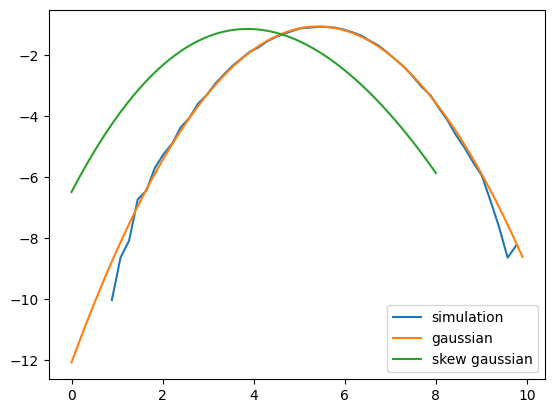

In [13]:
plt.plot(xs, np.log(ys), label="simulation")
mu = np.mean(YII_records)
sigma = np.std(YII_records)
def logtmpfun(y, mu, sigma):
    return (-((y-mu)/sigma)**2/2)-0.5*np.log(2*np.pi*sigma**2)
plt.plot(np.arange(0, 10, 0.1), logtmpfun(np.arange(0, 10, 0.1), mu, sigma), label="gaussian")
plt.plot(theory_YII[:, 0], np.log(theory_YII[:, 1]), label="skew gaussian")
plt.legend()


/tmp/ipykernel_3052/2443967885.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(xs, np.log(ys), label="simulation")


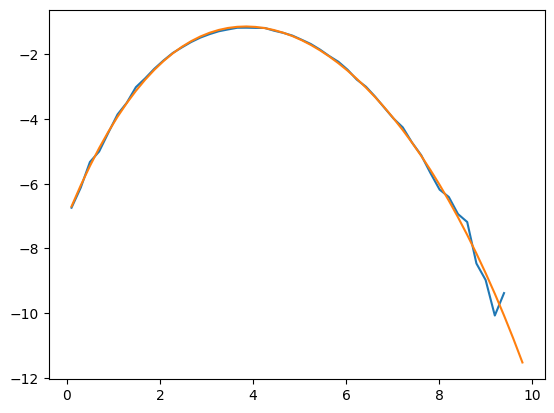

In [95]:
plt.plot(xs, np.log(ys), label="simulation")
poly2 = np.polyfit(xs[:-2], np.log(ys[:-2]), deg=2)
# plt.plot(xs, poly2[2]+poly2[1]*xs+poly2[0]*xs**2)
poly4 = np.polyfit(xs[:-2], np.log(ys[:-2]), deg=4)
plt.plot(xs, poly4[4]+poly4[3]*xs+poly4[2]*xs**2+poly4[1]*xs**3+poly4[0]*xs**4)

In [40]:
np.savetxt("tmp_data/tmpYII_distribution.txt", np.array([xs, ys]).T, fmt="%10.8f")

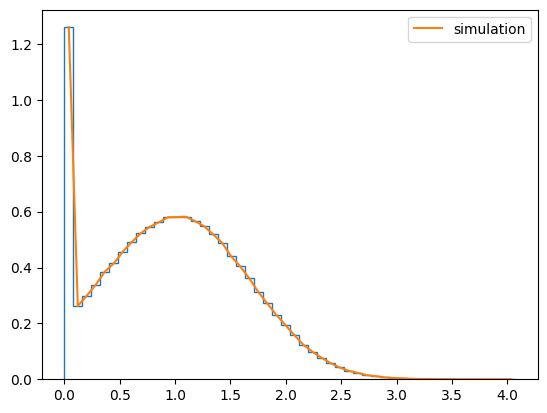

In [25]:
ys, xs, _ = plt.hist(zII_records, bins=50, density=True, histtype="step", cumulative=False)
xs = (xs[:-1]+xs[1:])/2
plt.plot(xs, ys, label="simulation")
def tmpfun(y, a, mu, sigma):
    return (1-a)*np.exp(-(y-mu)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2)/0.5/(1+erf(mu/sigma/np.sqrt(2.)))
def tmpfunCum(y, a, mu, sigma):
    return a + (1-a)*(erf((y-mu)/sigma/np.sqrt(2))+erf(mu/sigma/np.sqrt(2.)))/(1+erf(mu/sigma/np.sqrt(2.)))
# plt.plot(np.arange(0, 10, 0.1), tmpfun(np.arange(0, 10, 0.1), 0.000025, 4.19078, 1.26685))
# plt.plot(np.arange(0, 10, 0.1), tmpfun(np.arange(0, 10, 0.1), 0.0000, np.mean(zII_records), np.std(zII_records)), label="gaussian")
# plt.xlim(0, 8)
# plt.xlim(0, 2)
# plt.ylim(0, 0.05)
plt.legend()